In [1]:
import tensorflow as tf
from configuration import *
import io_utils

In [2]:
def extract_dataset_colors(dataset_path):
    dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        labels=None,
        color_mode="rgba",
        batch_size=None,
        image_size=(IMG_SIZE, IMG_SIZE)
    )

    empty_image = tf.zeros([IMG_SIZE, IMG_SIZE, INPUT_CHANNELS])
    image_of_whole_dataset = dataset.reduce(empty_image, lambda acc, image: tf.concat([acc, image], axis=0))

    palette = io_utils.extract_palette(image_of_whole_dataset, INPUT_CHANNELS, None)
    return palette

In [ ]:
for folder in DATA_FOLDERS:
    palette = extract_dataset_colors(folder)
    print("Palette for ", folder, ": ", tf.shape(palette))

Found 7296 files belonging to 1 classes.


In [2]:
def count_max_colors_in_image_from_dataset(dataset_path):
    ds = tf.keras.utils.image_dataset_from_directory(
            dataset_path,
            labels=None,
            color_mode="rgba",
            batch_size=None,
            image_size=(IMG_SIZE, IMG_SIZE)
        )
    ds = ds.map(lambda img: io_utils.extract_palette(img, fill_until_size=None))
    max = 0
    for palette in ds:
        size = tf.shape(palette)[0]
        max = size if size > max else max

    print("Largest is ", max)

count_max_colors_in_image_from_dataset("datasets/rpg-maker-xp/")

Found 1176 files belonging to 1 classes.
Largest is  tf.Tensor(54, shape=(), dtype=int32)


## Estudando o histograma

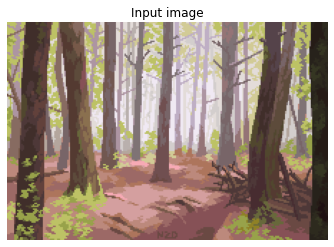

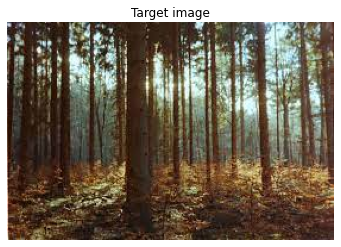

tf.shape(input_image) tf.Tensor([  1 608 896   3], shape=(4,), dtype=int32)
tf.shape(target_image) tf.Tensor([  1 183 275   3], shape=(4,), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min tf.Tensor(1.1346033e-09, shape=(), dtype=float32) max tf.Tensor(0.061995335, shape=(), dtype=float32)
min tf.Tensor(1.0917403e-09, shape=(), dtype=float32) max tf.Tensor(0.021703973, shape=(), dtype=float32)


<Figure size 432x288 with 0 Axes>

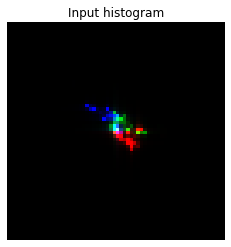

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


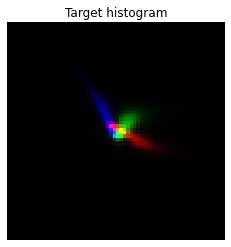

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\fegem\AppData\Local\Temp\ipykernel_2108\4073962281.py:61: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


Hellinger loss tf.Tensor(0.6140626, shape=(), dtype=float32)
L1 loss tf.Tensor(1.3657768, shape=(), dtype=float32)
L2 loss tf.Tensor(0.01633516, shape=(), dtype=float32)
L1 loss tf.Tensor(0.0001111472, shape=(), dtype=float32)
L2 loss tf.Tensor(1.3293587e-06, shape=(), dtype=float32)


InvalidArgumentError: required broadcastable shapes [Op:Sub]

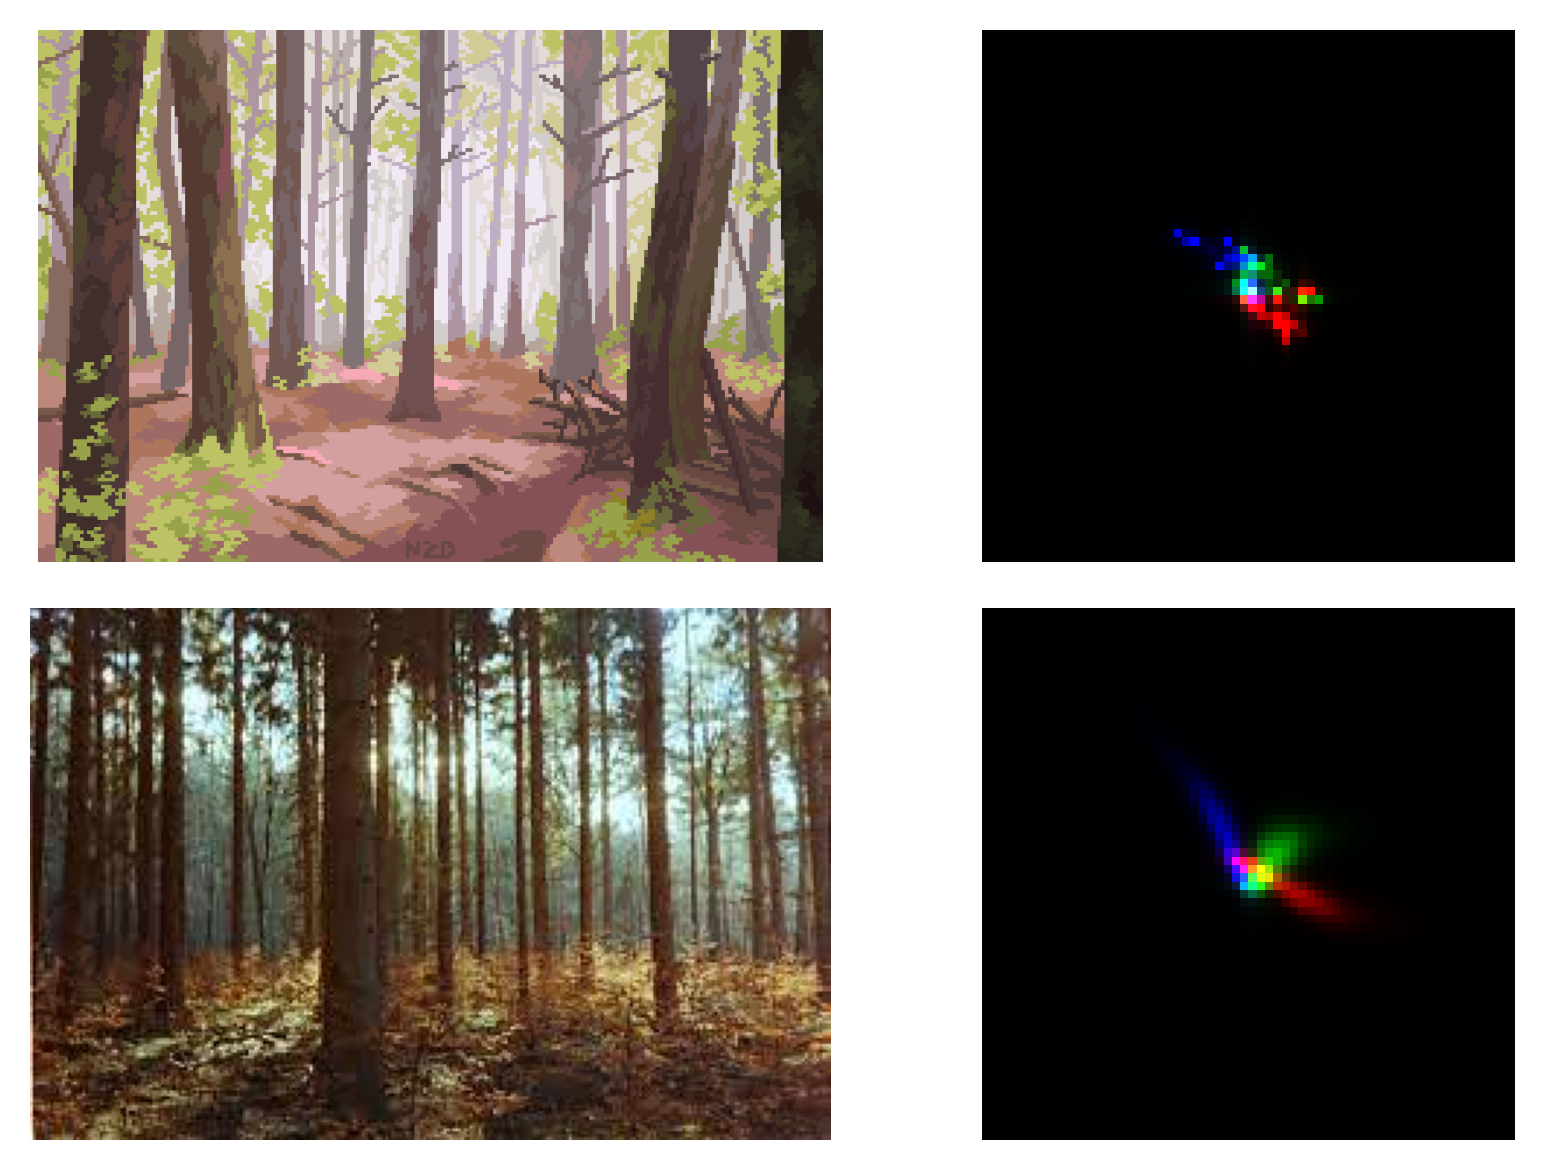

In [33]:
import tensorflow as tf
from histogram import calculate_rgbuv_histogram as calc, hellinger_loss as hloss, l1_loss, l2_loss
from matplotlib import pyplot as plt

def load_image(path):
    image = tf.keras.utils.load_img(path, color_mode="rgb")
    image = tf.cast(image, "float32")
    image = image / 127.5 - 1.
    image = image[tf.newaxis, ...]
    return image

def show_image(image, title=None):
    image = tf.squeeze(image)
    fig = plt.figure()
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.pause(0.001)


# input_image = load_image("docs/temp-generated-1-64x64.png")
# target_image = load_image("docs/temp-target-1-64x64.png")
input_image = load_image("docs/norma2dtumblr-pixel-art-creation.png")
target_image = load_image("docs/norma2dtumblr-pixel-art-similar.jpg")

show_image(input_image * 0.5 + 0.5, "Input image")
show_image(target_image * 0.5 + 0.5, "Target image")

print("tf.shape(input_image)", tf.shape(input_image))
print("tf.shape(target_image)", tf.shape(target_image))

input_histogram = calc(input_image)
target_histogram = calc(target_image)

print("min", tf.reduce_min(input_histogram), "max", tf.reduce_max(input_histogram))
print("min", tf.reduce_min(target_histogram), "max", tf.reduce_max(target_histogram))

plt.ion()
plt.figure()
show_image(input_histogram *100., "Input histogram")
show_image(target_histogram *100., "Target histogram")

# fig = plt.figure(dpi=300)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout=True, dpi=300)
# plt.subplot(2, 2, 1)
ax1.imshow(input_image[0]*0.5+0.5)
ax1.axis("off")

# plt.subplot(2, 2, 2)
ax2.imshow(input_histogram[0]*100.)
ax2.axis("off")

# plt.subplot(2, 2, 3)
ax3.imshow(target_image[0]*0.5+0.5)
ax3.axis("off")

# plt.subplot(2, 2, 4)
ax4.imshow(target_histogram[0]*100.)
ax4.axis("off")
plt.tight_layout()
# plt.subplots_adjust(wspace=0)

hellinger_los = hloss(input_histogram, target_histogram)
l1 = tf.reduce_mean(tf.reduce_sum(tf.abs(target_histogram - input_histogram), axis=[1, 2, 3]))
l2 = tf.reduce_mean(tf.reduce_sum(tf.pow(target_histogram - input_histogram, 2.), axis=[1, 2, 3]))
print("Hellinger loss", hellinger_los)
print("L1 loss", l1)
print("L2 loss", l2)
print("L1 loss", l1_loss(target_histogram, input_histogram))
print("L2 loss", l2_loss(target_histogram, input_histogram))

print("old l1", tf.reduce_mean(tf.abs(input_image - target_image)))
print("input shae", tf.shape(input_image))
print("tf.abs(input_image - target_image).shape", tf.abs(input_image - target_image).shape)
print("tf.reduce_sum(tf.abs(input_image - target_image), axis=[1,2,3])", tf.reduce_sum(tf.abs(input_image - target_image), axis=[1,2,3]))
print("new l1", tf.reduce_mean(tf.reduce_sum(tf.abs(input_image - target_image), axis=[1,2,3])))


mae = tf.keras.losses.MeanSquaredError()
mae(target_histogram, input_histogram).numpy()

## Intrinsic Dimensionality Estimation

In [9]:
# calculates the intrinsic dimensionality of datasets
import intdim_mle
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

def calculate_intdim(images):
    k1 = 10 # start of interval(included)
    k2 = 20 # end of interval(included)
    intdim_k_repeated = intdim_mle.repeated(intdim_mle.intrinsic_dim_scale_interval,
                                 images,
                                 mode="bootstrap",
                                 nb_iter=100, # nb_iter for bootstrapping
                                 verbose=1,
                                 k1=k1, k2=k2)
    intdim_k_repeated = np.array(intdim_k_repeated)
    # the shape of intdim_k_repeated is (nb_iter, size_of_interval) where
    # nb_iter is number of bootstrap iterations (here 500) and size_of_interval
    # is (k2 - k1 + 1).
    # Plotting the histogram of intrinsic dimensionality estimations repeated over
    # nb_iter experiments
    plt.hist(intdim_k_repeated.mean(axis=1))

    mean = intdim_k_repeated.mean()
    std = intdim_k_repeated.std()
    return mean, std

In [6]:
dataset_names = ["rpg-maker-2000", "rpg-maker-xp", "rpg-maker-vxace", "tiny-hero"]
dataset_folders = [[f"datasets/{name}/train/2-front/*.png", f"datasets/{name}/test/2-front/*.png"] for name in dataset_names]
print(dataset_folders)

[['datasets/rpg-maker-2000/train/2-front/*.png', 'datasets/rpg-maker-2000/test/2-front/*.png'], ['datasets/rpg-maker-xp/train/2-front/*.png', 'datasets/rpg-maker-xp/test/2-front/*.png'], ['datasets/rpg-maker-vxace/train/2-front/*.png', 'datasets/rpg-maker-vxace/test/2-front/*.png'], ['datasets/tiny-hero/train/2-front/*.png', 'datasets/tiny-hero/test/2-front/*.png']]


Calculating intrinsic dimensionality of rpg-maker-2000
Images found: 216


100%|██████████| 100/100 [03:03<00:00,  1.84s/it]


Intrinsic dimensionality for rpg-maker-2000 (mean/std): 12.5456 (0.63)
Calculating intrinsic dimensionality of rpg-maker-xp
Images found: 294


100%|██████████| 100/100 [03:21<00:00,  2.02s/it]


Intrinsic dimensionality for rpg-maker-xp (mean/std): 13.6626 (0.41)
Calculating intrinsic dimensionality of rpg-maker-vxace
Images found: 408


100%|██████████| 100/100 [03:35<00:00,  2.15s/it]


Intrinsic dimensionality for rpg-maker-vxace (mean/std): 13.5636 (0.77)
Calculating intrinsic dimensionality of tiny-hero
Images found: 912


100%|██████████| 100/100 [04:54<00:00,  2.95s/it]

Intrinsic dimensionality for tiny-hero (mean/std): 11.7704 (0.19)


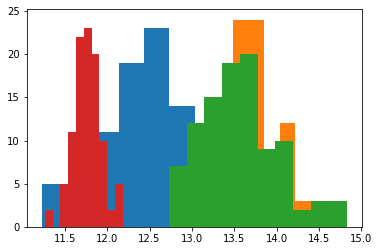

In [10]:
for dataset_folder, dataset_name in zip(dataset_folders, dataset_names):
    print(f"Calculating intrinsic dimensionality of {dataset_name}")
    ic = np.array(io.ImageCollection(dataset_folder))
    print("Images found:", ic.shape[0])
    ic = ic.reshape((ic.shape[0]), -1)
    intrinsic_dim, std = calculate_intdim(ic)
    print(f"Intrinsic dimensionality for {dataset_name} (mean/std):", f"{intrinsic_dim:.4f} ({std:.2f})")